In [1]:
import sys
sys.path.append("../")


import pickle
import torch
import math

from models.GLASE_unshared_normalized import gLASE
from torch_geometric.utils import to_dense_adj
from training.get_init import get_x_init
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CORA

In [8]:
## GENERATE EMBEDDINGS

dataset = 'cora'
mask = 'FULL'
device = 'cuda'
d = 6
gd_steps = 5


DATASET_FILE = f'../data/real_dataset/{dataset}_dataset.pkl'
Q_FILE = f'../data/real_dataset/{dataset}_q.pkl'
MASK_FILE = f'../data/real_dataset/{dataset}_mask_{mask}.pkl'
EMBEDDING_FILE = f'../data/real_dataset/{dataset}_glase_embeddings_d{d}_{gd_steps}steps_{mask}.pkl'
MODEL_FILE=f'../saved_models/{dataset}_glase_unshared_{gd_steps}steps_d{d}_{mask}.pt'


with open(DATASET_FILE, 'rb') as f:
    data = pickle.load(f)
data.to(device)

num_nodes = data.num_nodes
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

with open(MASK_FILE, 'rb') as f:
    mask_edge_index = pickle.load(f)
mask_edge_index = mask_edge_index.to(device)

with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)
Q = torch.diag(q[:d]).to(device)

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load(MODEL_FILE))
model.to('cuda')


/tmp/ipykernel_2387/2960402855.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE))


gLASE(
  (activation): Tanh()
  (gd): Sequential(
    (0) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (1) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (2) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (3) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (4) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
  )
)

In [9]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_elbows=2)
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

x_ase.shape

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


torch.Size([2708, 6])

In [5]:
with open(EMBEDDING_FILE, 'rb') as f:
    glase_emb = pickle.load(f)
glase_emb

tensor([[ 0.4819,  0.7279,  0.6431,  0.6880,  0.6826,  1.0899],
        [-0.0430,  0.0642, -0.0812, -0.0886, -0.1439,  0.0085],
        [ 0.1035,  0.1994,  0.1413,  0.1968,  0.1349,  0.3028],
        ...,
        [ 0.3868,  0.5611,  0.4895,  0.5531,  0.5395,  0.8517],
        [ 0.4010,  0.5719,  0.5305,  0.6182,  0.6124,  0.8833],
        [ 0.2163,  0.3264,  0.2912,  0.3481,  0.3102,  0.5122]],
       device='cuda:0', requires_grad=True)

In [6]:
cora_embeddings = {}

for i in range(10):
    print(i)
    torch.manual_seed(i)
    x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
    model.eval()
    x_glase = model(x_init, data.edge_index, edge_index_2, Q, mask_edge_index).detach()
    cora_embeddings[i] = x_glase

0
1
2
3
4
5
6
7
8
9


In [11]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

ase_loss = torch.norm((x_ase@Q@x_ase.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("ASE loss: ", ase_loss)

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


ASE loss:  tensor(101.2766, device='cuda:0')


In [12]:
## GRPDG - GD
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD: ", loss_gd_5)

Loss GRDPG GD:  tensor(103.4983, device='cuda:0')


In [13]:
## GRPDG - GD 5 steps
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index, max_iter = 5)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD - 5 steps: ", loss_gd_5)

Loss GRDPG GD - 5 steps:  tensor(126.8629, device='cuda:0')


In [14]:
## GLASE Loss 
glase_loss = torch.norm((glase_emb@Q@glase_emb.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("GLASE loss: ", glase_loss)

GLASE loss:  tensor(102.8400, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


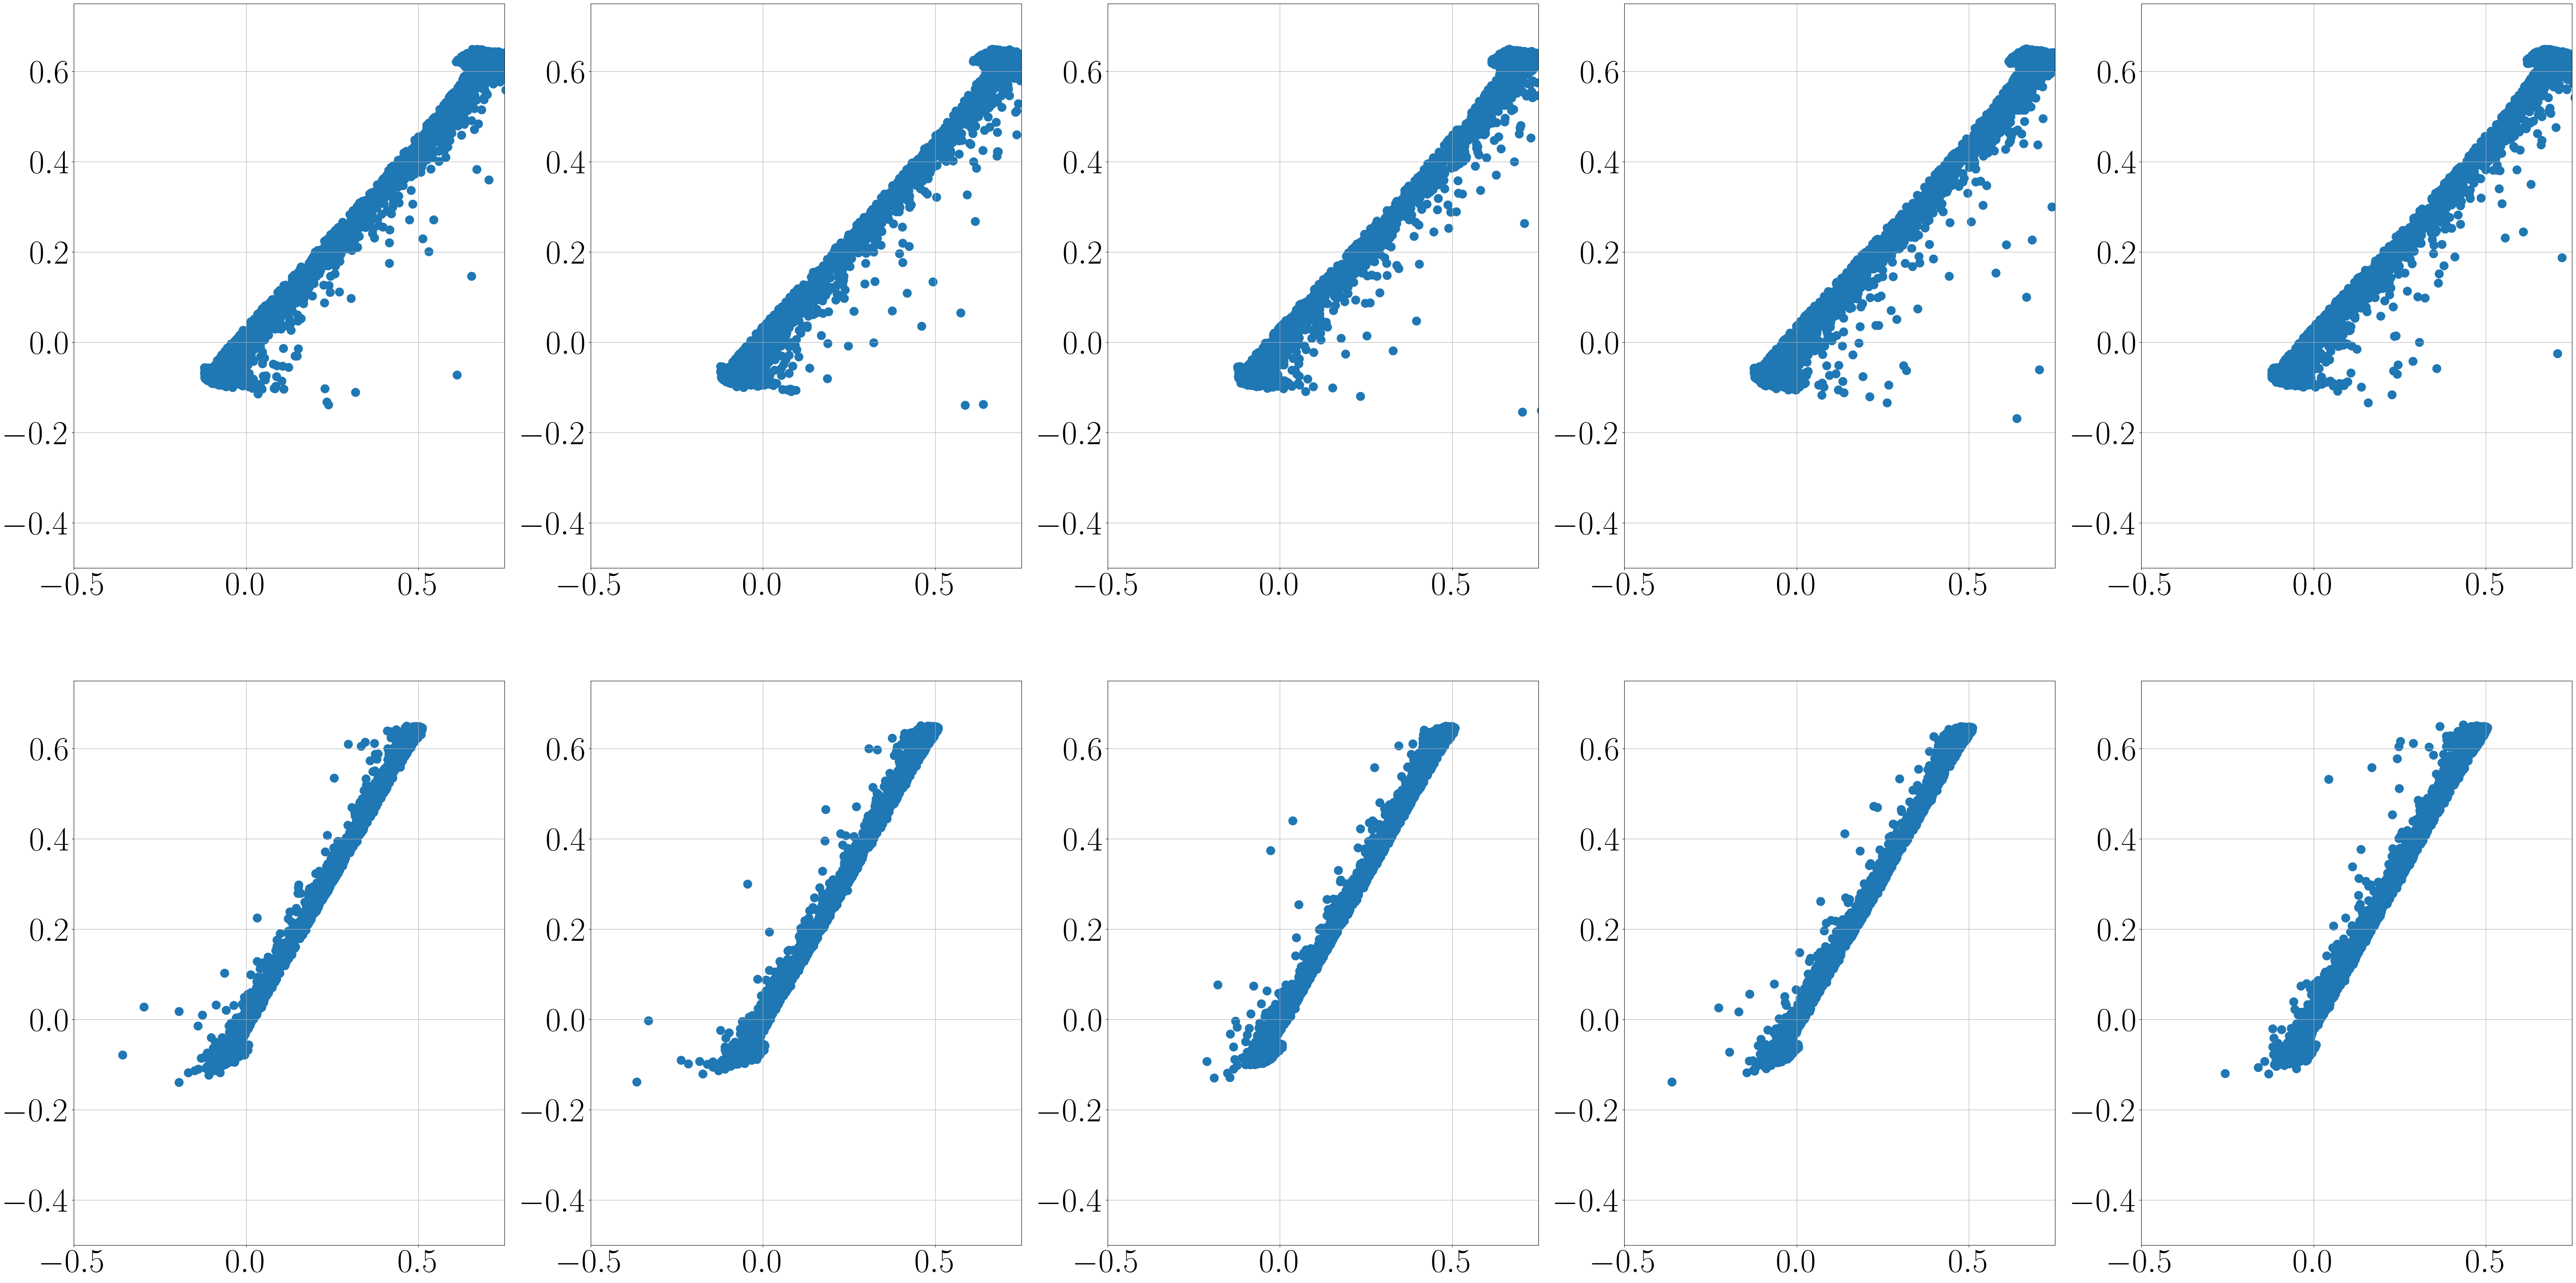

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 60
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(2, 5, figsize =(80,40))

axes[0,0].scatter(cora_embeddings[0][:,3].to('cpu'), cora_embeddings[0][:,2].to('cpu'))
axes[0,1].scatter(cora_embeddings[1][:,3].to('cpu'), cora_embeddings[1][:,2].to('cpu'))
axes[0,2].scatter(cora_embeddings[2][:,3].to('cpu'), cora_embeddings[2][:,2].to('cpu'))
axes[0,3].scatter(cora_embeddings[3][:,3].to('cpu'), cora_embeddings[3][:,2].to('cpu'))
axes[0,4].scatter(cora_embeddings[4][:,3].to('cpu'), cora_embeddings[4][:,2].to('cpu'))

axes[1,0].scatter(cora_embeddings[5][:,0].to('cpu'), cora_embeddings[5][:,2].to('cpu'))
axes[1,1].scatter(cora_embeddings[6][:,0].to('cpu'), cora_embeddings[6][:,2].to('cpu'))
axes[1,2].scatter(cora_embeddings[7][:,0].to('cpu'), cora_embeddings[7][:,2].to('cpu'))
axes[1,3].scatter(cora_embeddings[8][:,0].to('cpu'), cora_embeddings[8][:,2].to('cpu'))
axes[1,4].scatter(cora_embeddings[9][:,0].to('cpu'), cora_embeddings[9][:,2].to('cpu'))

axes[0,0].set_xlim(-0.5,0.75)
axes[0,1].set_xlim(-0.5,0.75)
axes[0,2].set_xlim(-0.5,0.75)
axes[0,3].set_xlim(-0.5,0.75)
axes[0,4].set_xlim(-0.5,0.75)
axes[1,0].set_xlim(-0.5,0.75)
axes[1,1].set_xlim(-0.5,0.75)
axes[1,2].set_xlim(-0.5,0.75)
axes[1,3].set_xlim(-0.5,0.75)
axes[1,4].set_xlim(-0.5,0.75)

axes[0,0].set_ylim(-0.5,0.75)
axes[0,1].set_ylim(-0.5,0.75)
axes[0,2].set_ylim(-0.5,0.75)
axes[0,3].set_ylim(-0.5,0.75)
axes[0,4].set_ylim(-0.5,0.75)
axes[1,0].set_ylim(-0.5,0.75)
axes[1,1].set_ylim(-0.5,0.75)
axes[1,2].set_ylim(-0.5,0.75)
axes[1,3].set_ylim(-0.5,0.75)
axes[1,4].set_ylim(-0.5,0.75)

plt.show()

# Citeseer

In [12]:
## GENERATE EMBEDDINGS

dataset = 'citeseer'
mask = 'FULL'
device = 'cuda'
d = 6
gd_steps = 5


DATASET_FILE = f'../data/real_dataset/{dataset}_dataset.pkl'
Q_FILE = f'../data/real_dataset/{dataset}_q.pkl'
MASK_FILE = f'../data/real_dataset/{dataset}_mask_{mask}.pkl'
EMBEDDING_FILE = f'../data/real_dataset/{dataset}_glase_embeddings_d{d}_{gd_steps}steps_{mask}.pkl'
MODEL_FILE=f'../saved_models/citeseer/{dataset}_glase_unshared_{gd_steps}steps_d{d}_{mask}.pt'


with open(DATASET_FILE, 'rb') as f:
    data = pickle.load(f)
data.to(device)

num_nodes = data.num_nodes
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

with open(MASK_FILE, 'rb') as f:
    mask_edge_index = pickle.load(f)
mask_edge_index = mask_edge_index.to(device)

with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)
Q = torch.diag(q[:d]).to(device)
print(q)

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load(MODEL_FILE))
model.to('cuda')


tensor([ 1.,  1.,  1., -1., -1., -1.])


/tmp/ipykernel_2387/329614625.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE))


gLASE(
  (activation): Tanh()
  (gd): Sequential(
    (0) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (1) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (2) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (3) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (4) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
  )
)

In [13]:
citeseer_embeddings = {}

for i in range(10):
    print(i)
    torch.manual_seed(i)
    x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
    model.eval()
    x_glase = model(x_init, data.edge_index, edge_index_2, Q, mask_edge_index).detach()
    citeseer_embeddings[i] = x_glase

0
1
2
3
4
5
6
7
8
9


In [14]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_elbows=2)
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

x_ase.shape

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


torch.Size([3327, 6])

In [21]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

ase_loss = torch.norm((x_ase@Q@x_ase.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("ASE loss: ", ase_loss)


## GRPDG - GD
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD: ", loss_gd_5)


## GRPDG - GD 5 steps
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index, max_iter = 5)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD - 5 steps: ", loss_gd_5)

## GLASE Loss 
with open(EMBEDDING_FILE, 'rb') as f:
    glase_emb = pickle.load(f)
glase_loss = torch.norm((glase_emb@Q@glase_emb.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("GLASE loss: ", glase_loss)

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


ASE loss:  tensor(98.1736, device='cuda:0')
Loss GRDPG GD:  tensor(96.0612, device='cuda:0')
Loss GRDPG GD - 5 steps:  tensor(148.5515, device='cuda:0')
GLASE loss:  tensor(102.1087, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


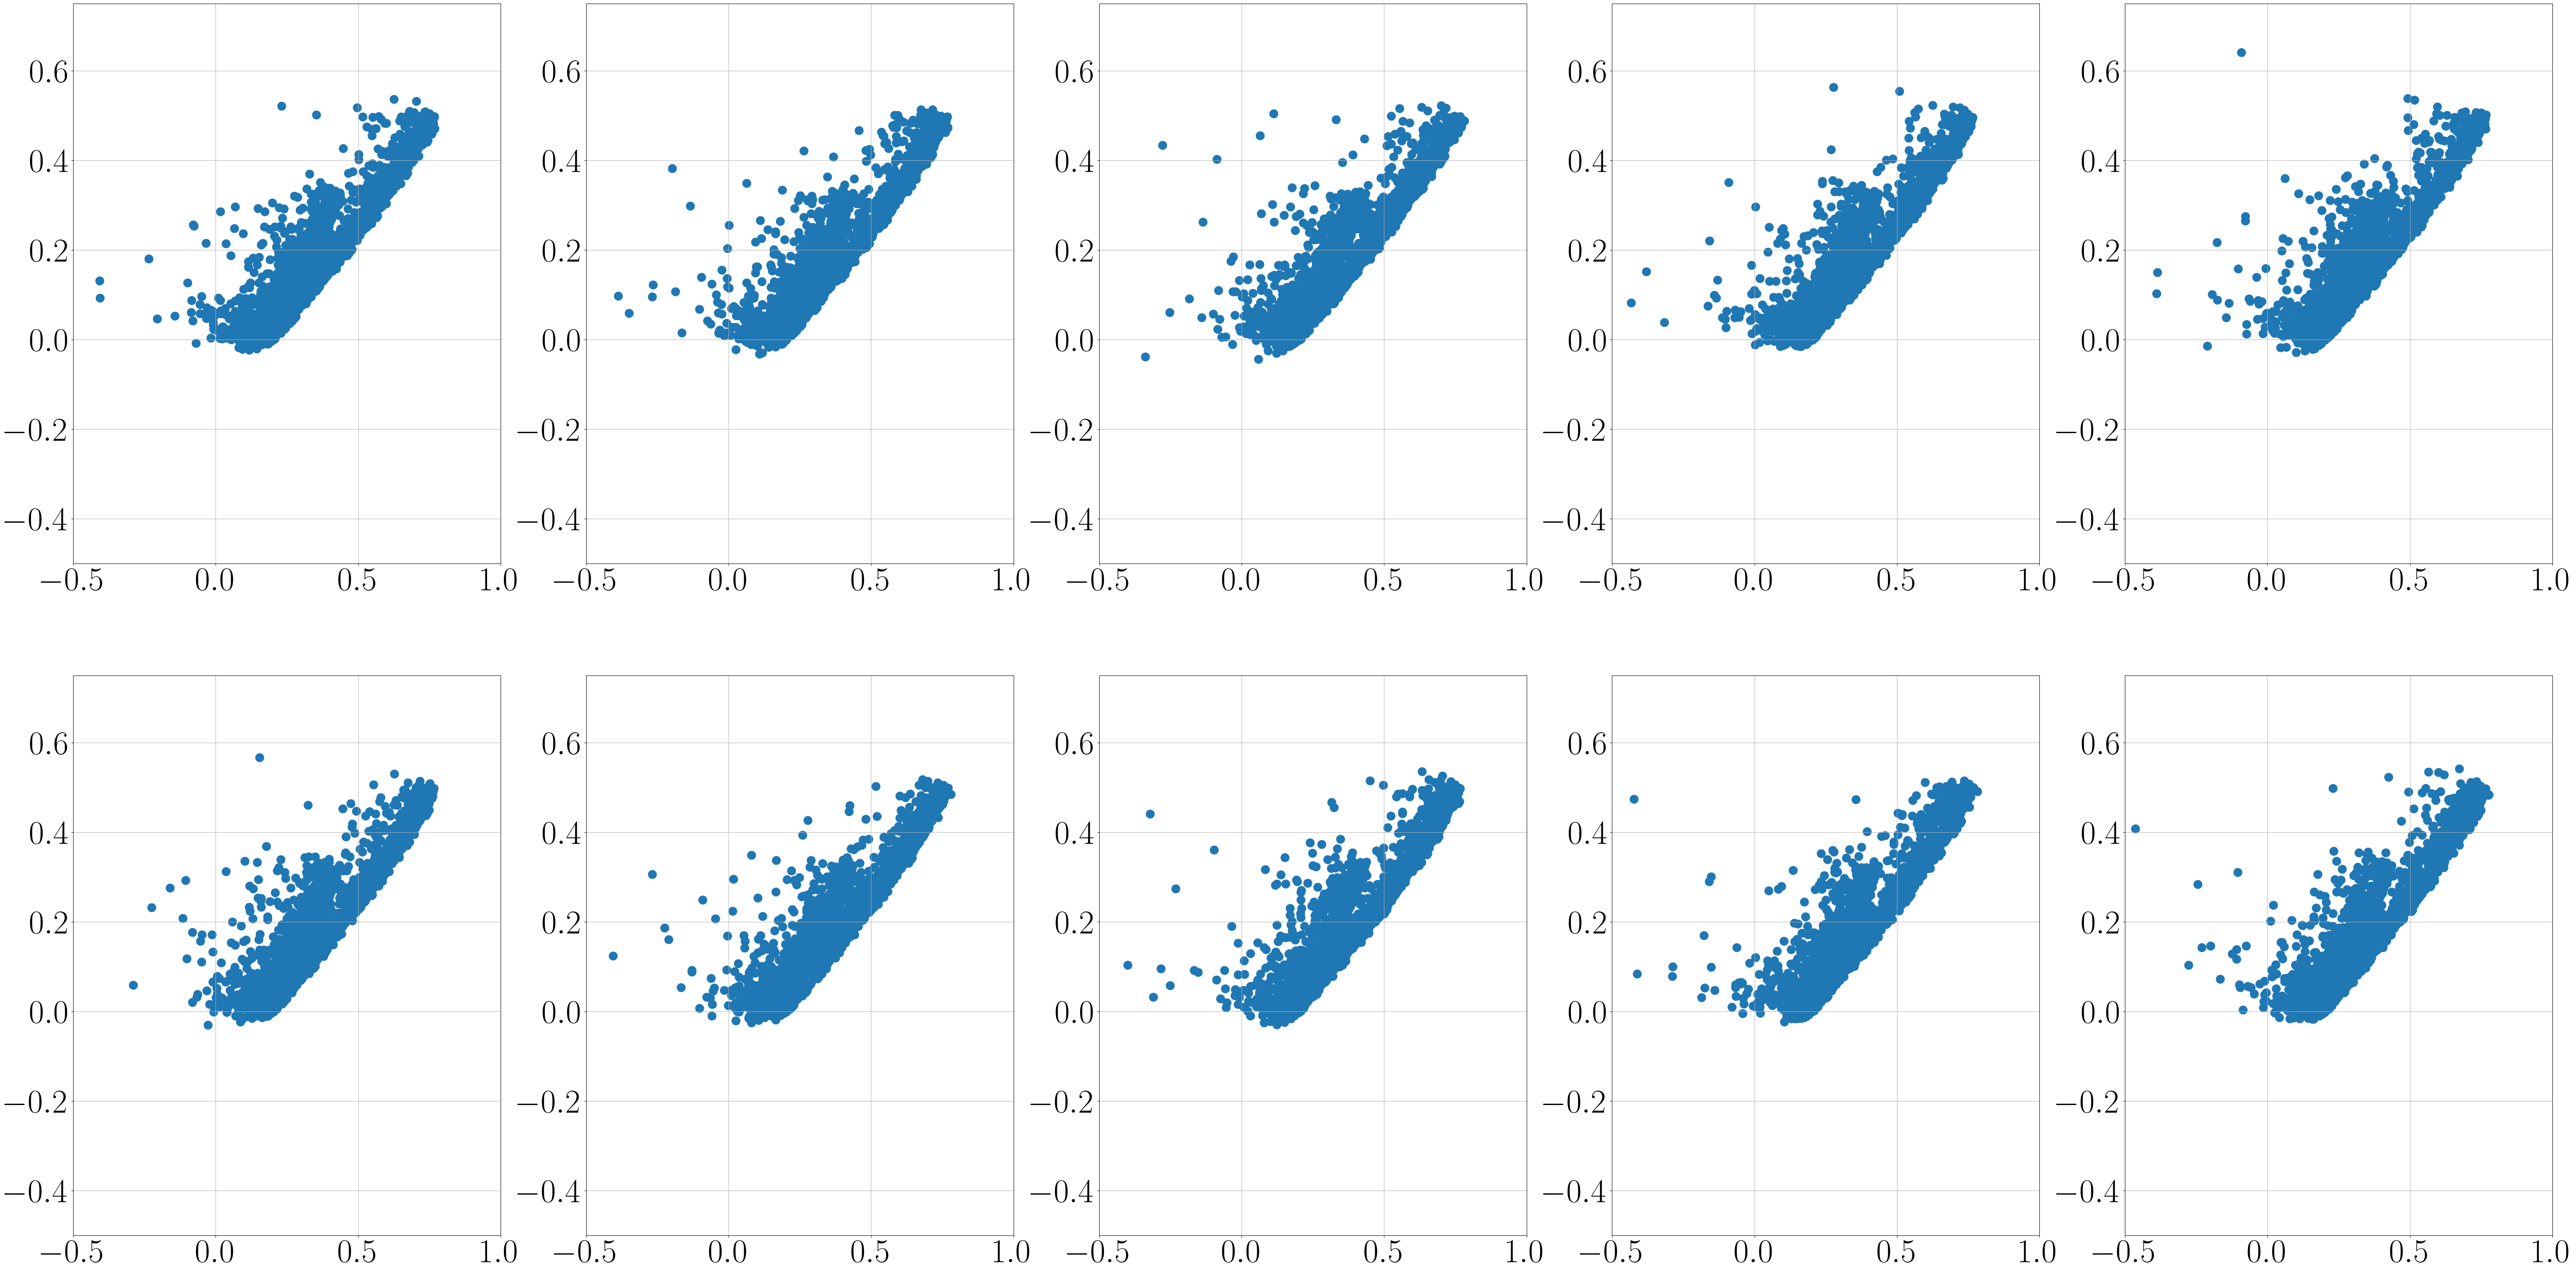

In [18]:
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 60
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(2, 5, figsize =(80,40))

axes[0,0].scatter(citeseer_embeddings[0][:,0].to('cpu'), citeseer_embeddings[0][:,2].to('cpu'))
axes[0,1].scatter(citeseer_embeddings[1][:,0].to('cpu'), citeseer_embeddings[1][:,2].to('cpu'))
axes[0,2].scatter(citeseer_embeddings[2][:,0].to('cpu'), citeseer_embeddings[2][:,2].to('cpu'))
axes[0,3].scatter(citeseer_embeddings[3][:,0].to('cpu'), citeseer_embeddings[3][:,2].to('cpu'))
axes[0,4].scatter(citeseer_embeddings[4][:,0].to('cpu'), citeseer_embeddings[4][:,2].to('cpu'))
axes[1,0].scatter(citeseer_embeddings[5][:,0].to('cpu'), citeseer_embeddings[5][:,2].to('cpu'))
axes[1,1].scatter(citeseer_embeddings[6][:,0].to('cpu'), citeseer_embeddings[6][:,2].to('cpu'))
axes[1,2].scatter(citeseer_embeddings[7][:,0].to('cpu'), citeseer_embeddings[7][:,2].to('cpu'))
axes[1,3].scatter(citeseer_embeddings[8][:,0].to('cpu'), citeseer_embeddings[8][:,2].to('cpu'))
axes[1,4].scatter(citeseer_embeddings[9][:,0].to('cpu'), citeseer_embeddings[9][:,2].to('cpu'))

axes[0,0].set_xlim(-0.5,1)
axes[0,1].set_xlim(-0.5,1)
axes[0,2].set_xlim(-0.5,1)
axes[0,3].set_xlim(-0.5,1)
axes[0,4].set_xlim(-0.5,1)
axes[1,0].set_xlim(-0.5,1)
axes[1,1].set_xlim(-0.5,1)
axes[1,2].set_xlim(-0.5,1)
axes[1,3].set_xlim(-0.5,1)
axes[1,4].set_xlim(-0.5,1)

axes[0,0].set_ylim(-0.5,0.75)
axes[0,1].set_ylim(-0.5,0.75)
axes[0,2].set_ylim(-0.5,0.75)
axes[0,3].set_ylim(-0.5,0.75)
axes[0,4].set_ylim(-0.5,0.75)
axes[1,0].set_ylim(-0.5,0.75)
axes[1,1].set_ylim(-0.5,0.75)
axes[1,2].set_ylim(-0.5,0.75)
axes[1,3].set_ylim(-0.5,0.75)
axes[1,4].set_ylim(-0.5,0.75)

plt.show()

# Twitch

In [18]:
## GENERATE EMBEDDINGS

dataset = 'Twitch_ES'
mask = 'FULL'
device = 'cuda'
d = 2
gd_steps = 5


DATASET_FILE = f'../data/real_dataset/{dataset}_dataset.pkl'
Q_FILE = f'../data/real_dataset/{dataset}_q.pkl'
MASK_FILE = f'../data/real_dataset/{dataset}_mask_{mask}.pkl'
EMBEDDING_FILE = f'../data/real_dataset/{dataset}_glase_embeddings_d{d}_{gd_steps}steps_{mask}.pkl'
MODEL_FILE=f'../saved_models/{dataset}/{dataset}_glase_unshared_{gd_steps}steps_d{d}_{mask}.pt'


with open(DATASET_FILE, 'rb') as f:
    data = pickle.load(f)
data.to(device)

num_nodes = data.num_nodes
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

with open(MASK_FILE, 'rb') as f:
    mask_edge_index = pickle.load(f)
mask_edge_index = mask_edge_index.to(device)

with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)
Q = torch.diag(q[:d]).to(device)
print(q)

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load(MODEL_FILE))
model.to('cuda')


tensor([ 1., -1.])


/tmp/ipykernel_2387/626700019.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE))


gLASE(
  (activation): Tanh()
  (gd): Sequential(
    (0) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (1) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (2) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (3) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
    (4) - GD_Block(): x, edge_index, edge_index_2, Q, mask -> x
  )
)

In [19]:
twitch_embeddings = {}

for i in range(10):
    print(i)
    torch.manual_seed(i)
    x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
    model.eval()
    x_glase = model(x_init, data.edge_index, edge_index_2, Q, mask_edge_index).detach()
    twitch_embeddings[i] = x_glase

0
1
2
3
4
5
6
7
8
9


In [22]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_elbows=2)
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)
x_ase.shape

torch.Size([4648, 7])

In [ ]:
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

ase_loss = torch.norm((x_ase@Q@x_ase.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("ASE loss: ", ase_loss)


In [ ]:
## GRPDG - GD
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index)
x_grdpg = x_grdpg.detach()
loss_gd = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD: ", loss_gd)


## GRPDG - GD 5 steps
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index, max_iter = 5)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD - 5 steps: ", loss_gd_5)

## GLASE Loss 
with open(EMBEDDING_FILE, 'rb') as f:
    glase_emb = pickle.load(f)
glase_loss = torch.norm((glase_emb@Q@glase_emb.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("GLASE loss: ", glase_loss)

ASE loss:  tensor(351.6525, device='cuda:0')
Loss GRDPG GD:  tensor(336.5569, device='cuda:0')
Loss GRDPG GD - 5 steps:  tensor(336.5347, device='cuda:0')
GLASE loss:  tensor(334.6382, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


# Amazon

In [15]:
## GENERATE EMBEDDINGS

dataset = 'amazon'
mask = 'FULL'
device = 'cuda'
d = 8
gd_steps = 10

DATASET_FILE = f'../data/real_dataset/{dataset}_dataset.pkl'
Q_FILE = f'../data/real_dataset/{dataset}_q.pkl'
MASK_FILE = f'../data/real_dataset/{dataset}_mask_{mask}.pkl'
EMBEDDING_FILE = f'../data/real_dataset/{dataset}_glase_embeddings_d{d}_{gd_steps}steps_{mask}.pkl'


with open(DATASET_FILE, 'rb') as f:
    data = pickle.load(f)
data.to(device)

num_nodes = data.num_nodes
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

with open(MASK_FILE, 'rb') as f:
    mask_edge_index = pickle.load(f)
mask_edge_index = mask_edge_index.to(device)

with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)
Q = torch.diag(q[:d]).to(device)
print(q)

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.])


In [16]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_elbows=2)
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

x_ase.shape

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


torch.Size([7650, 6])

In [17]:
## ASE EMBEDDINGS
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes = num_nodes).squeeze(0)
mask_matrix = to_dense_adj(mask_edge_index, max_num_nodes = num_nodes).squeeze(0)
masked_adj = (adj_matrix*mask_matrix).to('cpu')
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase).to(device)

ase_loss = torch.norm((x_ase@Q@x_ase.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("ASE loss: ", ase_loss)


## GRPDG - GD
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index)
x_grdpg = x_grdpg.detach()
loss_gd = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print(k)
print("Loss GRDPG GD: ", loss_gd)


## GRPDG - GD 5 steps
x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_init, data.edge_index, Q, mask_edge_index, max_iter = 5)
x_grdpg = x_grdpg.detach()
loss_gd_5 = torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))

print("Loss GRDPG GD - 5 steps: ", loss_gd_5)

## GLASE Loss 
with open(EMBEDDING_FILE, 'rb') as f:
    glase_emb = pickle.load(f)
glase_loss = torch.norm((glase_emb@Q@glase_emb.T - to_dense_adj(data.edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0))
print("GLASE loss: ", glase_loss)

/home/sofia/lase/repo/LASE/env/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


ASE loss:  tensor(469.7419, device='cuda:0')
19
Loss GRDPG GD:  tensor(481.0959, device='cuda:0')
Loss GRDPG GD - 5 steps:  tensor(501.9202, device='cuda:0')
GLASE loss:  tensor(453.1349, device='cuda:0')


In [30]:


# DATASET_FILE = f'../data/real_dataset/{dataset}_dataset.pkl'

MASK_FILE = f'../data/real_dataset/{dataset}_mask_{mask}.pkl'
EMBEDDING_FILE = f'../data/real_dataset/{dataset}_glase_embeddings_d{d}_{gd_steps}steps_{mask}.pkl'
MODEL_FILE=f'../saved_models/{dataset}_glase_unshared_{gd_steps}steps_d{d}_{mask}.pt'


# with open(DATASET_FILE, 'rb') as f:
#     data = pickle.load(f)
# data.to(device)

num_nodes = data.num_nodes
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

with open(MASK_FILE, 'rb') as f:
    mask = pickle.load(f)
mask = mask.to(device)

with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)
Q = torch.diag(q[:d]).to(device)
print(q)

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load(MODEL_FILE))
model.to('cuda')


FileNotFoundError: [Errno 2] No such file or directory: '../data/real_dataset/amazon_dataset.pkl'

In [27]:
amazon_embeddings = {}

for i in range(10):
    print(i)
    torch.manual_seed(i)
    x_init = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)
    model.eval()
    x_glase = model(x_init, data.edge_index, edge_index_2, Q, mask).detach()
    amazon_embeddings[i] = x_glase

0


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB (GPU 0; 11.76 GiB total capacity; 11.17 GiB already allocated; 124.81 MiB free; 11.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF